**Approach**

Below are the steps I have taken, in order, to arrive at the final results:

1. Analysed all the variables and filtered data for year > 2019 as enough data is not present for years 2018 and 2019.
2. Analysed the distribution of all categories and created 6 new categories to club the existing ones.
3. Created a table data at customer-year level which consists of monthly average expenses and monthly average transactions for all the newly created categories and the reamining categories.
4. Created another table at customer-year level with aggregated salary (extrapolated for 2021) and monthly average transactions.
5. Merged these two tables and used all the features to build an xgboost regressor model to estimate the annual salary for all customers.

# Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor 
import sklearn
pd.set_option('display.max_rows', 500)
# To execute a cell line by line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1. Loading the data and overview

In [2]:
# To display quick overview of the data
def DataOverview(df):
    print('Shape of the Data:'+ str(df.shape) + '\n')   # To Find number of rows and columns
    print('Datatypes of Columns:',df.dtypes)            # Exploring the datatypes of the columns
    head = df.head()
    return head                                         # To view few top rows of the data

In [3]:
df = pd.read_csv('petal_cf_trans.csv')
DataOverview(df)

Shape of the Data:(61820, 8)

Datatypes of Columns: sid                        int64
ingest_datetime           object
aggregator_account_id     object
transaction_id            object
transaction_date          object
trans_memo                object
amount                   float64
category                  object
dtype: object


,sid,ingest_datetime,aggregator_account_id,transaction_id,transaction_date,trans_memo,amount,category
0,99055734,7/24/2019 18:48,KYLVk6BzvkFwQ9vVvDm8h5xORQgb65uQyJZrL,wbAnXx0aKXcoaDNeNpbVuDJVa1rD86ULeRgO7,11/5/2018,pos/check card withdrawal / riccardos italian ...,-6.03,Account Transfer
1,99055734,7/24/2019 18:48,KYLVk6BzvkFwQ9vVvDm8h5xORQgb65uQyJZrL,dODrkqEdxkcyQ4L6LpqzTvgMzK5vxAUb8oLkz,11/5/2018,pos/check card withdrawal / smartpay-north cli...,-66.27,Account Transfer
2,99055734,7/24/2019 18:48,KYLVk6BzvkFwQ9vVvDm8h5xORQgb65uQyJZrL,mNAbJX13wJuk3bdKdR4MsVnXJozVwmfMm8QRw,11/5/2018,ach withdrawal synchrony bank / - cc pymt,-50.00,ATM/Cash
3,99055734,7/24/2019 18:48,KYLVk6BzvkFwQ9vVvDm8h5xORQgb65uQyJZrL,zbOwnZ48XncZ8AO5OPQ4f1k7oxQ1VYIOzMRay,11/6/2018,ach withdrawal capital one - / mobile pmt,-94.61,Credit Card Payment
4,99055734,7/24/2019 18:48,KYLVk6BzvkFwQ9vVvDm8h5xORQgb65uQyJZrL,Ye1mwb8zjwh0ZE9a9pkJuMZxjJzMPNFQnzYN5,11/7/2018,pos/check card withdrawal / royal car wash - r...,-19.39,Account Transfer


In [4]:
# To Find Total Count, Total #Unique values, Total #Missing values and Missing value percentage

def DescriptionTable(df):
    DescriptionTable = pd.DataFrame()
    DescriptionTable['TotalCount'] = df.count()             #Total number of values present in the columns
    DescriptionTable['MissingCount'] = df.isnull().sum()    #Total number of Missing values present in the columns
    DescriptionTable['MissingPercent'] = round((df.isnull().sum()/df.shape[0])*100, 2)    #Missing values percentage
    DescriptionTable.set_index(df.columns, inplace=True)    #Setting column names as index for dataframe
    return DescriptionTable  

In [5]:
df_DescriptionTable = DescriptionTable(df)
df_DescriptionTable

,TotalCount,MissingCount,MissingPercent
sid,61820,0,0.0
ingest_datetime,61820,0,0.0
aggregator_account_id,61820,0,0.0
transaction_id,61820,0,0.0
transaction_date,61820,0,0.0
trans_memo,61820,0,0.0
amount,61820,0,0.0
category,61820,0,0.0


We observe that there are no missing values in the data.

In [6]:
# Changing the 'transaction_date' column type to date and creating year, month and day columns
df['transaction_date'].dtypes
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['day'] = df['transaction_date'].dt.day
df['month'] = df['transaction_date'].dt.month
df['year'] = df['transaction_date'].dt.year

dtype('O')

# 2. Variable analysis

Total category types :  31


Account Transfer        21711
Uncategorized            8129
Refunds                  6139
Food and Beverages       5709
ATM/Cash                 3070
General Merchandise      2617
Automotive               2068
Groceries                1707
Paychecks/Salary         1654
Travel                   1379
Misc Inflows             1141
Loans                     982
Credit Card Payment       913
Healthcare/Medical        875
Bills/Utilities           842
Entertainment             786
Unemployment              359
Home Improvement          281
Insurance                 265
Personal Care             223
Clothing/Shoes            217
Interest                  142
Account Fees              134
Postage and Shipping      105
Taxes                     103
Pets/Pet Care              90
Business Misc              81
Gifts/Donations            58
Education                  29
Mortgages                   7
Child/Dependents            4
Name: category, dtype: int64

<Figure size 864x648 with 0 Axes>

Text(0.5, 1.0, 'Count of categories')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text major ticklabel objects>)

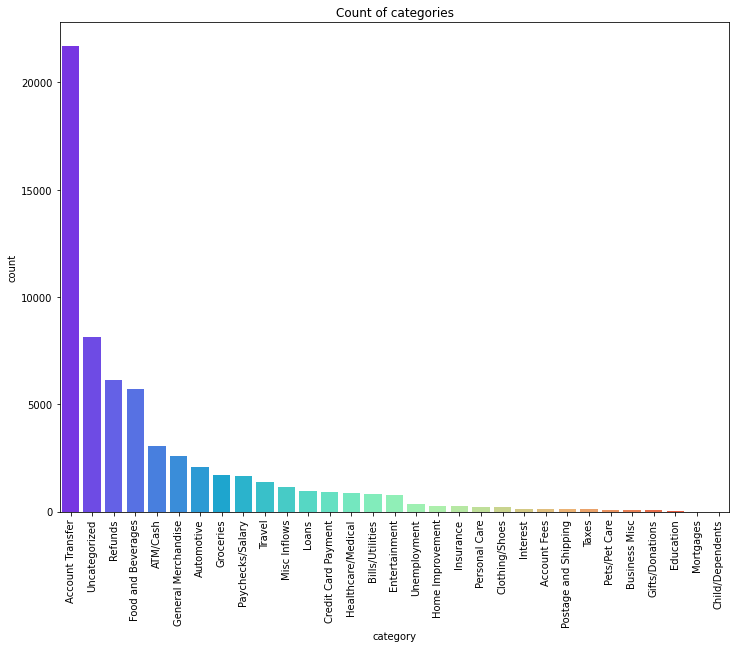

In [7]:
# Checking the distribution of categories
print("Total category types : ",df['category'].nunique())
df['category'].value_counts()

plt.figure(figsize=(12,9))
sns.countplot(x='category',data= df, order = df['category'].value_counts().index, palette='rainbow', orient = "h")
plt.title("Count of categories")
plt.xticks(rotation=90)
plt.show()

In [8]:
# Checking the minimum and maximum dates
print("Minimum date : " ,df['transaction_date'].min())
print("Maximum date : " ,df['transaction_date'].max())

Minimum date :  2018-10-29 00:00:00
Maximum date :  2021-09-22 00:00:00


We have 4 years of data, from 2018 to 2021.

In [9]:
# Checking number of customers 
print("Total number of customers : " ,df['sid'].nunique())

# Checking number of transactions 
print("Total number of transactions : " ,df['transaction_id'].nunique())

Total number of customers :  59
Total number of transactions :  61820


In [10]:
# Checking the distribution of transactions and customers over years
df.groupby(['year']).agg({'transaction_id':'nunique', 'sid':'nunique'})

,transaction_id,sid
year,,
2018,434,3
2019,2933,6
2020,23035,46
2021,35418,48


In [11]:
# Checking the distribution of transactions and customers over years and months
df.groupby(['year', 'month']).agg({'transaction_id':'nunique', 'sid':'nunique'})

transaction_id  sid
year month                     
2018 10                 28    1
     11                183    3
     12                223    3
2019 1                 223    3
     2                 272    3
     3                 274    3
     4                 277    4
     5                 347    4
     6                 378    4
     7                 294    4
     8                  95    2
     9                  84    1
     10                107    2
     11                309    3
     12                273    3
2020 1                 254    3
     2                 491    5
     3                 751    6
     4                 887    7
     5                 917    8
     6                1264    9
     7                1170    9
     8                1452   21
     9                3183   24
     10               3612   30
     11               3806   35
     12               5248   40
2021 1                5949   48
     2                5392   47
     3                7095   45
     4                5943   44
     5                3486   33
     6                3090   26
     7                2536   21
     8                1503   18
     9                 424    9

From the data, I observed that for the years 2018 and 2019, we have data of only 3 and 6 customers respectively and also, for the year 2021, we only have data till septemeber and not for the months after that. In order to estimate the annual salary, I will only consider the data of 2020 and 2021 moving ahead. 

# 3. Category analysis

Analysing the distributions of categories in order to club them.

In [12]:
# Filtering data after 2019
df_gt2019 = df[df['year'] > 2019]
df_gt2019.shape

(58453, 11)

In [13]:
# Checking number of customers 
print("Total number of customers : " ,df_gt2019['sid'].nunique())

# Checking number of transactions 
print("Total number of transactions : " ,df_gt2019['category'].nunique())

Total number of customers :  55
Total number of transactions :  31


In [14]:
# Checking the distribution of number of months of data available, number of transactions and total expenditure for different categories and years

df_cust = df_gt2019.groupby(['category', 'year']).agg({'sid':'nunique', 'month':'nunique', 'transaction_id':'nunique', 'amount' : 'sum'})
df_cust.reset_index(inplace = True)
df_cust = df_cust.rename({'month' : '#months', 'transaction_id':'#transactions', 'amount' :'total_exp'}, axis = 1)
df_cust.shape
df_cust.head()

(61, 6)

,category,year,sid,#months,#transactions,total_exp
0,ATM/Cash,2020,46,12,911,217650.75
1,ATM/Cash,2021,48,9,1967,461397.44
2,Account Fees,2020,13,11,45,-1821.94
3,Account Fees,2021,16,8,81,-3104.27
4,Account Transfer,2020,46,12,8090,-226752.98


In [15]:
# Calculating the monthly average expense for each category and year 
df_cust['monthly_avg_exp'] = np.where(df_cust['year'] == 2021, df_cust['#transactions']/9, df_cust['#transactions']/12)

# Calculating the monthly average transactions for each category and year 
df_cust['monthly_avg_trans'] = np.where(df_cust['year'] == 2021, df_cust['#transactions']/9, df_cust['#transactions']/12)

df_cust.shape
df_cust.head()

(61, 8)

,category,year,sid,#months,#transactions,total_exp,monthly_avg_exp,monthly_avg_trans
0,ATM/Cash,2020,46,12,911,217650.75,75.916667,75.916667
1,ATM/Cash,2021,48,9,1967,461397.44,218.555556,218.555556
2,Account Fees,2020,13,11,45,-1821.94,3.750000,3.750000
3,Account Fees,2021,16,8,81,-3104.27,9.000000,9.000000
4,Account Transfer,2020,46,12,8090,-226752.98,674.166667,674.166667


In [16]:
# Looking at the dsitrbution for year 2020
df_cust[df_cust['year'] == 2020].sort_values('total_exp', ascending = False)

,category,year,sid,#months,#transactions,total_exp,monthly_avg_exp,monthly_avg_trans
43,Paychecks/Salary,2020,38,12,711,297374.13,59.250000,59.250000
0,ATM/Cash,2020,46,12,911,217650.75,75.916667,75.916667
40,Misc Inflows,2020,34,12,362,136328.04,30.166667,30.166667
59,Unemployment,2020,12,11,160,84344.81,13.333333,13.333333
51,Refunds,2020,46,12,2710,11932.74,225.833333,225.833333
53,Taxes,2020,8,11,28,9207.32,2.333333,2.333333
36,Interest,2020,15,12,56,7.17,4.666667,4.666667
12,Child/Dependents,2020,2,2,2,-94.41,0.166667,0.166667
26,Gifts/Donations,2020,9,6,21,-597.47,1.750000,1.750000
10,Business Misc,2020,8,8,32,-652.43,2.666667,2.666667


In [17]:
# Looking at the distrbution for year 2021
df_cust[df_cust['year'] == 2021].sort_values('total_exp', ascending = False)

,category,year,sid,#months,#transactions,total_exp,monthly_avg_exp,monthly_avg_trans
44,Paychecks/Salary,2021,38,9,782,659495.19,86.888889,86.888889
1,ATM/Cash,2021,48,9,1967,461397.44,218.555556,218.555556
41,Misc Inflows,2021,48,9,660,310267.70,73.333333,73.333333
60,Unemployment,2021,9,9,190,89620.00,21.111111,21.111111
54,Taxes,2021,26,8,66,68260.50,7.333333,7.333333
39,Loans,2021,34,9,528,48371.29,58.666667,58.666667
37,Interest,2021,18,9,79,9.31,8.777778,8.777778
13,Child/Dependents,2021,1,1,2,-47.61,0.222222,0.222222
19,Education,2021,5,5,14,-1890.32,1.555556,1.555556
27,Gifts/Donations,2021,11,8,36,-2096.74,4.000000,4.000000


After looking at the distributions of different categories, I was able to come up with a set of new categories to combines these existing categories and reduce the total number of categories.

1. Shopping - Personal Care, Clothing/Shoes, Entertainment, Home Improvement
2. Misc Inflows - Misc Inflows, Taxes, Interes
3. Misc Bills - Travel,groceries, bills, healthcare
4. Liabilities - Insurance, credit card, mortgages
5. Gifts/Pets/Child/Busi  - Gifts/Donations, Pets/Pet Care, Child/Dependents, Business Misc
6. Edu/Acc/Post - Education, account fees, postage/shipping

I have done this in order to reduce the number of features for the regression model to estimate annual salary.

# 4. Customer-Category level data 

In [18]:
# Checking the distribution of number of months of data available, number of transactions and total expenditure for different customers within each category and year

df_cust = df_gt2019.groupby(['sid','category', 'year']).agg({'month':'nunique', 'transaction_id':'nunique', 'amount' : 'sum'})
df_cust.reset_index(inplace = True)
df_cust = df_cust.rename({'month' : '#months', 'transaction_id':'#transactions', 'amount' :'total_exp'}, axis = 1)
df_cust.shape
df_cust.head()

(1660, 6)

,sid,category,year,#months,#transactions,total_exp
0,990174352,ATM/Cash,2021,7,18,-13.41
1,990174352,Account Transfer,2021,9,155,12318.82
2,990174352,Automotive,2021,7,23,-643.44
3,990174352,Bills/Utilities,2021,1,1,-21.74
4,990174352,Business Misc,2021,3,3,-711.43


In [19]:
# Removing the Paycheck/Salary records to build the model as it is our response variable

df_cust = df_cust[df_cust['category'] != 'Paychecks/Salary']
df_cust.shape

(1584, 6)

In [20]:
# Calculating the monthly average expense for each customer, category and year 
df_cust['monthly_avg_exp'] = np.where(df_cust['year'] == 2021, df_cust['total_exp']/9, df_cust['total_exp']/12)

# Calculating the monthly average transactions for each customer, category and year 
df_cust['monthly_avg_trans'] = np.where(df_cust['year'] == 2021, df_cust['#transactions']/9, df_cust['#transactions']/12)
df_cust.head()

,sid,category,year,#months,#transactions,total_exp,monthly_avg_exp,monthly_avg_trans
0,990174352,ATM/Cash,2021,7,18,-13.41,-1.490000,2.000000
1,990174352,Account Transfer,2021,9,155,12318.82,1368.757778,17.222222
2,990174352,Automotive,2021,7,23,-643.44,-71.493333,2.555556
3,990174352,Bills/Utilities,2021,1,1,-21.74,-2.415556,0.111111
4,990174352,Business Misc,2021,3,3,-711.43,-79.047778,0.333333


In [21]:
# Coverting the category rows into columns to have monthly average expense and transaction information for each category as a column 

df_cust_pivot = pd.pivot_table(df_cust, values = ['monthly_avg_exp', 'monthly_avg_trans'], index=['sid','year'], columns = 'category').reset_index()
df_cust_pivot.columns = df_cust_pivot.columns.map('_'.join)
df_cust_pivot.reset_index(inplace = True)
df_cust_pivot = df_cust_pivot.drop('index', 1)
df_cust_pivot = df_cust_pivot.rename({'sid_' : 'sid', 'year_':'year'}, axis = 1)
df_cust_pivot.head()
df_cust_pivot.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,sid,year,monthly_avg_exp_ATM/Cash,monthly_avg_exp_Account Fees,monthly_avg_exp_Account Transfer,monthly_avg_exp_Automotive,monthly_avg_exp_Bills/Utilities,monthly_avg_exp_Business Misc,monthly_avg_exp_Child/Dependents,monthly_avg_exp_Clothing/Shoes,...,monthly_avg_trans_Misc Inflows,monthly_avg_trans_Mortgages,monthly_avg_trans_Personal Care,monthly_avg_trans_Pets/Pet Care,monthly_avg_trans_Postage and Shipping,monthly_avg_trans_Refunds,monthly_avg_trans_Taxes,monthly_avg_trans_Travel,monthly_avg_trans_Uncategorized,monthly_avg_trans_Unemployment
0,990174352,2021,-1.490000,NaN,1368.757778,-71.493333,-2.415556,-79.047778,NaN,-98.532222,...,0.555556,NaN,0.333333,0.222222,0.222222,16.444444,0.333333,NaN,7.222222,NaN
1,990508621,2020,59.558333,-6.0375,-457.876667,-351.299167,-41.514167,-0.902500,-5.5775,NaN,...,1.833333,NaN,0.166667,NaN,0.083333,1.833333,0.166667,3.250000,14.333333,0.50
2,990596991,2020,-106.000000,NaN,-788.321667,NaN,-33.433333,NaN,NaN,NaN,...,0.666667,NaN,NaN,NaN,NaN,1.166667,NaN,0.416667,2.083333,NaN
3,990596991,2021,-200.336667,NaN,-873.910000,NaN,-88.888889,NaN,NaN,NaN,...,0.444444,NaN,NaN,NaN,NaN,0.666667,0.222222,NaN,2.666667,NaN
4,990728591,2020,41.666667,NaN,-71.275000,-14.255833,NaN,NaN,NaN,NaN,...,0.083333,NaN,0.333333,NaN,NaN,17.666667,NaN,NaN,2.083333,0.25


(94, 62)

In [22]:
# Filling null values with zeros and rounding all the values to two decimals
df_cust_pivot = df_cust_pivot.fillna(0)
df_cust_pivot = df_cust_pivot.round(2)

In [23]:
# Combining - Gifts/Donations, Pets/Pet Care, Child/Dependents, Business Misc and dropping those columns
df_cust_pivot['monthly_avg_exp_Gifts/Pets/Child/Busi'] = df_cust_pivot['monthly_avg_exp_Business Misc'] + df_cust_pivot['monthly_avg_exp_Child/Dependents'] + df_cust_pivot['monthly_avg_exp_Pets/Pet Care'] + df_cust_pivot['monthly_avg_exp_Gifts/Donations']
df_cust_pivot['monthly_avg_trans_Gifts/Pets/Child/Busi'] = df_cust_pivot['monthly_avg_trans_Business Misc'] + df_cust_pivot['monthly_avg_trans_Child/Dependents'] + df_cust_pivot['monthly_avg_trans_Pets/Pet Care'] + df_cust_pivot['monthly_avg_trans_Gifts/Donations']
df_cust_pivot = df_cust_pivot.drop(columns = ['monthly_avg_exp_Business Misc', 'monthly_avg_exp_Child/Dependents','monthly_avg_exp_Pets/Pet Care','monthly_avg_exp_Gifts/Donations', 'monthly_avg_trans_Business Misc', 'monthly_avg_trans_Child/Dependents', 'monthly_avg_trans_Pets/Pet Care', 'monthly_avg_trans_Gifts/Donations'])

In [24]:
# Combining - Personal Care, Clothing/Shoes, Entertainment, Home Improvement and dropping those columns
df_cust_pivot['monthly_avg_exp_Shopping'] = df_cust_pivot['monthly_avg_exp_Clothing/Shoes'] + df_cust_pivot['monthly_avg_exp_Entertainment'] + df_cust_pivot['monthly_avg_exp_Home Improvement'] + df_cust_pivot['monthly_avg_exp_Personal Care']
df_cust_pivot['monthly_avg_trans_Shopping'] = df_cust_pivot['monthly_avg_trans_Clothing/Shoes'] + df_cust_pivot['monthly_avg_trans_Entertainment'] + df_cust_pivot['monthly_avg_trans_Home Improvement'] + df_cust_pivot['monthly_avg_trans_Personal Care']
df_cust_pivot = df_cust_pivot.drop(columns = ['monthly_avg_exp_Clothing/Shoes', 'monthly_avg_exp_Entertainment','monthly_avg_exp_Home Improvement','monthly_avg_exp_Personal Care', 'monthly_avg_trans_Clothing/Shoes', 'monthly_avg_trans_Entertainment', 'monthly_avg_trans_Home Improvement', 'monthly_avg_trans_Personal Care'])

In [25]:
# Combining - Education, account fees, postage/shipping and dropping those columns
df_cust_pivot['monthly_avg_exp_Edu/acc/post'] = df_cust_pivot['monthly_avg_exp_Education'] + df_cust_pivot['monthly_avg_exp_Account Fees'] + df_cust_pivot['monthly_avg_exp_Postage and Shipping']
df_cust_pivot['monthly_avg_trans_Edu/acc/post'] = df_cust_pivot['monthly_avg_trans_Education'] + df_cust_pivot['monthly_avg_trans_Account Fees'] + df_cust_pivot['monthly_avg_trans_Postage and Shipping'] 
df_cust_pivot = df_cust_pivot.drop(columns = ['monthly_avg_exp_Education', 'monthly_avg_exp_Account Fees','monthly_avg_exp_Postage and Shipping', 'monthly_avg_trans_Education', 'monthly_avg_trans_Account Fees', 'monthly_avg_trans_Postage and Shipping'])

In [26]:
# Combining - Misc Inflows, Taxes, Interes and dropping those columns
df_cust_pivot['monthly_avg_exp_Misc Inflows'] = df_cust_pivot['monthly_avg_exp_Misc Inflows'] + df_cust_pivot['monthly_avg_exp_Taxes'] + df_cust_pivot['monthly_avg_exp_Interest']
df_cust_pivot['monthly_avg_trans_Misc Inflows'] = df_cust_pivot['monthly_avg_trans_Misc Inflows'] + df_cust_pivot['monthly_avg_trans_Taxes'] + df_cust_pivot['monthly_avg_trans_Interest'] 
df_cust_pivot = df_cust_pivot.drop(columns = ['monthly_avg_exp_Taxes', 'monthly_avg_exp_Interest', 'monthly_avg_trans_Taxes', 'monthly_avg_trans_Interest'])

In [27]:
# Combining -Travel,groceries, bills, healthcare and dropping those columns
df_cust_pivot['monthly_avg_exp_Misc Bills'] = df_cust_pivot['monthly_avg_exp_Travel'] + df_cust_pivot['monthly_avg_exp_Groceries'] + df_cust_pivot['monthly_avg_exp_Bills/Utilities'] + df_cust_pivot['monthly_avg_exp_Healthcare/Medical']
df_cust_pivot['monthly_avg_trans_Misc Bills'] = df_cust_pivot['monthly_avg_trans_Travel'] + df_cust_pivot['monthly_avg_trans_Groceries'] + df_cust_pivot['monthly_avg_trans_Bills/Utilities'] + df_cust_pivot['monthly_avg_trans_Healthcare/Medical'] 
df_cust_pivot = df_cust_pivot.drop(columns = ['monthly_avg_exp_Travel', 'monthly_avg_exp_Groceries', 'monthly_avg_exp_Bills/Utilities', 'monthly_avg_exp_Healthcare/Medical', 'monthly_avg_trans_Travel', 'monthly_avg_trans_Groceries', 'monthly_avg_trans_Bills/Utilities', 'monthly_avg_trans_Healthcare/Medical'])

In [28]:
# Combining - Insurance, credit card, mortgages and dropping those columns
df_cust_pivot['monthly_avg_exp_Liabilities'] = df_cust_pivot['monthly_avg_exp_Insurance'] + df_cust_pivot['monthly_avg_exp_Credit Card Payment'] + df_cust_pivot['monthly_avg_exp_Mortgages']
df_cust_pivot['monthly_avg_trans_Liabilities'] = df_cust_pivot['monthly_avg_trans_Insurance'] + df_cust_pivot['monthly_avg_trans_Credit Card Payment'] + df_cust_pivot['monthly_avg_trans_Mortgages'] 
df_cust_pivot = df_cust_pivot.drop(columns = ['monthly_avg_exp_Insurance', 'monthly_avg_exp_Credit Card Payment', 'monthly_avg_exp_Mortgages', 'monthly_avg_trans_Insurance', 'monthly_avg_trans_Credit Card Payment', 'monthly_avg_trans_Mortgages'])

In [29]:
df_cust_pivot.shape
df_cust_pivot.head()

(94, 32)

,sid,year,monthly_avg_exp_ATM/Cash,monthly_avg_exp_Account Transfer,monthly_avg_exp_Automotive,monthly_avg_exp_Food and Beverages,monthly_avg_exp_General Merchandise,monthly_avg_exp_Loans,monthly_avg_exp_Misc Inflows,monthly_avg_exp_Refunds,...,monthly_avg_exp_Gifts/Pets/Child/Busi,monthly_avg_trans_Gifts/Pets/Child/Busi,monthly_avg_exp_Shopping,monthly_avg_trans_Shopping,monthly_avg_exp_Edu/acc/post,monthly_avg_trans_Edu/acc/post,monthly_avg_exp_Misc Bills,monthly_avg_trans_Misc Bills,monthly_avg_exp_Liabilities,monthly_avg_trans_Liabilities
0,990174352,2021,-1.49,1368.76,-71.49,-199.55,-212.33,-10.03,942.61,-433.71,...,-109.79,0.55,-197.85,5.33,-21.17,0.22,-172.17,3.66,-175.77,1.55
1,990508621,2020,59.56,-457.88,-351.30,-132.71,-165.29,-0.50,1938.12,-10.37,...,-6.48,0.16,-73.84,4.75,-14.35,0.50,-139.03,6.00,-99.40,0.92
2,990596991,2020,-106.00,-788.32,0.00,0.00,0.00,0.00,202.54,-70.68,...,0.00,0.00,0.00,0.00,0.00,0.00,-69.76,1.59,-463.59,4.16
3,990596991,2021,-200.34,-873.91,0.00,0.00,0.00,0.00,802.78,-14.73,...,0.00,0.00,0.00,0.00,0.00,0.00,-149.83,1.56,-635.46,6.00
4,990728591,2020,41.67,-71.27,-14.26,-58.20,-68.14,-1.42,50.01,-6.19,...,0.00,0.00,-13.16,0.91,0.00,0.00,-14.26,0.50,-8.76,0.08


Now we have the data at customer and year level and have information about monthly average expenses and transactions for each category, which I will use as features for my model.

# 5. Salary analysis

In [30]:
# Filtering data only Paychecks/Salary transactions
df_salary = df_gt2019[df_gt2019['category'] == 'Paychecks/Salary']
df_salary.shape
df_salary.head(2)

(1493, 11)

,sid,ingest_datetime,aggregator_account_id,transaction_id,transaction_date,trans_memo,amount,category,day,month,year
603,991299512,6/10/2021 0:27,DJYPy9eO51cYzeq7ejzOce4eBYEB6vsZx1yzY,mY4ZKOxjRJHkB7zQ7XBvhkQZodRNvaTMOy0PL,2020-10-05,int*quickbooks online 800-446-8848 ca 1...,-25.0,Paychecks/Salary,5,10,2020
616,991299512,6/10/2021 0:27,DJYPy9eO51cYzeq7ejzOce4eBYEB6vsZx1yzY,YYpLOKdM4wH0nYroYBn3FBo6Jrk7mqHQV3abA,2020-10-06,intuit *payroll 888-537-7794 ca 1...,-58.0,Paychecks/Salary,6,10,2020


In [31]:
# Checking number of customers 
print("Total number of customers : " ,df_salary['sid'].nunique())

# Checking number of transactions 
print("Total number of transactions : " ,df_salary['transaction_id'].nunique())

Total number of customers :  45
Total number of transactions :  1493


In [32]:
# Checking the salary distribution of each customer for every month and year
df_salary1 = df_salary.groupby(['sid', 'year','month']).agg({'transaction_id':"nunique", 'amount':'sum', 'transaction_date' : [np.min, np.max]})
df_salary1.columns = df_salary1.columns.map('_'.join)
df_salary1.reset_index(inplace = True)
df_salary1.head()

,sid,year,month,transaction_id_nunique,amount_sum,transaction_date_amin,transaction_date_amax
0,990508621,2020,3,1,10.00,2020-03-30,2020-03-30
1,990508621,2020,5,1,187.07,2020-05-26,2020-05-26
2,990508621,2020,6,1,0.01,2020-06-10,2020-06-10
3,990596991,2020,8,2,2104.12,2020-08-28,2020-08-31
4,990596991,2020,9,4,4386.04,2020-09-15,2020-09-30


In [33]:
# Summing up the total salary and transactions for each customer and year
df_salary2 = df_salary1.groupby(['sid', 'year']).agg({'month':'nunique', 'transaction_id_nunique' : 'sum', 'amount_sum':'sum'})
df_salary2.reset_index(inplace = True)
df_salary2 = df_salary2.rename({'month' : '#months', 'transaction_id_nunique':'#transactions', 'amount_sum' :'yearly_salary'}, axis = 1)
df_salary2.head()

,sid,year,#months,#transactions,yearly_salary
0,990508621,2020,3,3,197.08
1,990596991,2020,5,19,17603.94
2,990596991,2021,4,14,13677.71
3,991000632,2020,1,3,2109.47
4,991000632,2021,5,10,10640.74


For the year 2021, we have data only till september so I extrapolated the salary information for the rest of the months to find the average.

In [34]:
# Extrapolating the salary information for year 2021
df_salary2['salary_new'] = np.where(df_salary2['year'] == 2021, (df_salary2['yearly_salary']/9)*12, df_salary2['yearly_salary'])
df_salary2['salary_new'] = np.round(df_salary2['salary_new'],2)

In [35]:
# Calculating the monthly average transactions for each customer and year
df_salary2['monthly_avg_salary_trans'] = np.where(df_salary2['year'] == 2021, df_salary2['#transactions']/9, df_salary2['#transactions']/12)
df_salary2['monthly_avg_salary_trans'] = np.round(df_salary2['monthly_avg_salary_trans'],1)

In [36]:
df_salary2.shape
df_salary2.head()

(76, 7)

,sid,year,#months,#transactions,yearly_salary,salary_new,monthly_avg_salary_trans
0,990508621,2020,3,3,197.08,197.08,0.2
1,990596991,2020,5,19,17603.94,17603.94,1.6
2,990596991,2021,4,14,13677.71,18236.95,1.6
3,991000632,2020,1,3,2109.47,2109.47,0.2
4,991000632,2021,5,10,10640.74,14187.65,1.1


# 6. Modeling

In [37]:
# Merging the customer-category level data with customer-salary data
df_final = pd.merge(df_salary2, df_cust_pivot, how='inner', on = ['sid', 'year'], sort=True)
df_final1 = df_final.drop(columns = ['#months', '#transactions', 'yearly_salary'])
df_final1.shape
df_final1.head()

(76, 34)

,sid,year,salary_new,monthly_avg_salary_trans,monthly_avg_exp_ATM/Cash,monthly_avg_exp_Account Transfer,monthly_avg_exp_Automotive,monthly_avg_exp_Food and Beverages,monthly_avg_exp_General Merchandise,monthly_avg_exp_Loans,...,monthly_avg_exp_Gifts/Pets/Child/Busi,monthly_avg_trans_Gifts/Pets/Child/Busi,monthly_avg_exp_Shopping,monthly_avg_trans_Shopping,monthly_avg_exp_Edu/acc/post,monthly_avg_trans_Edu/acc/post,monthly_avg_exp_Misc Bills,monthly_avg_trans_Misc Bills,monthly_avg_exp_Liabilities,monthly_avg_trans_Liabilities
0,990508621,2020,197.08,0.2,59.56,-457.88,-351.30,-132.71,-165.29,-0.50,...,-6.48,0.16,-73.84,4.75,-14.35,0.50,-139.03,6.00,-99.40,0.92
1,990596991,2020,17603.94,1.6,-106.00,-788.32,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-69.76,1.59,-463.59,4.16
2,990596991,2021,18236.95,1.6,-200.34,-873.91,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-149.83,1.56,-635.46,6.00
3,991000632,2020,2109.47,0.2,-5.00,-51.10,-27.60,-11.86,-23.26,0.00,...,0.00,0.00,-1.79,0.25,0.00,0.00,-2.41,0.16,0.00,0.00
4,991000632,2021,14187.65,1.1,38.36,-1044.41,-162.81,-171.60,-424.10,-4.43,...,-102.23,1.89,-47.07,1.66,-4.58,0.44,-126.84,4.56,-10.67,0.56


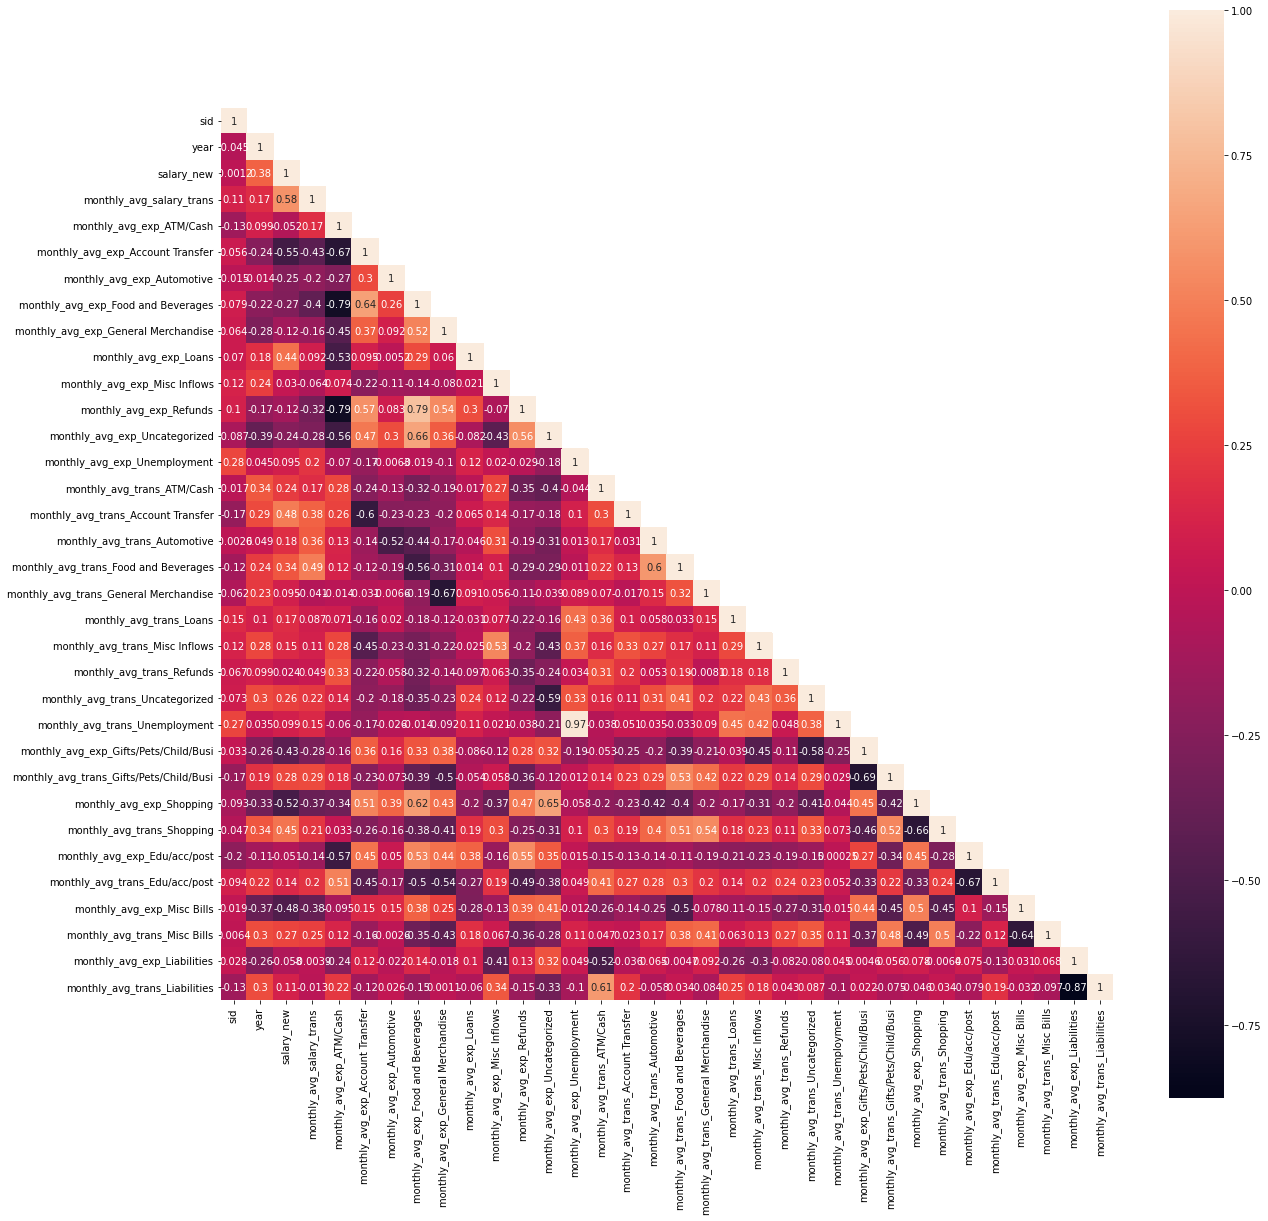

In [38]:
# Checking correlation between the features
cor_mat = df_final1[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(20,20)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [48]:
# Creating X and y varaibles to implement the model
X = df_final1.drop(columns = ['salary_new', 'monthly_avg_salary_trans'])
y = df_final[['salary_new']]

# Splitting the data into test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=1)

In [40]:
NUMBER_KFOLDS = 5
RANDOM_STATE = 2018
VERBOSE_EVAL = 50
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 

In [41]:
# Set xgboost parameters
params = {}
params['objective'] = 'reg:squarederror'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'rmse'
params['random_state'] = RANDOM_STATE

In [42]:
# Preparing the train and test data
dtrain = xgb.DMatrix(X_train, y_train.values)
dtest = xgb.DMatrix(X_test, y_test.values)

watchlist = [(dtrain, 'train'), (dtest, 'valid')]

In [43]:
# Building an xgboost model
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True)

[0]	train-rmse:17999.2	valid-rmse:32397.6
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1]	train-rmse:17612	valid-rmse:32038
[2]	train-rmse:17128.9	valid-rmse:31611.4
[3]	train-rmse:16663	valid-rmse:31299.9
[4]	train-rmse:16291.3	valid-rmse:30979.9
[5]	train-rmse:15944.1	valid-rmse:30688.3
[6]	train-rmse:15533.8	valid-rmse:30310.6
[7]	train-rmse:15167.8	valid-rmse:30010.5
[8]	train-rmse:14869.5	valid-rmse:29831
[9]	train-rmse:14508.6	valid-rmse:29594.7
[10]	train-rmse:14242.7	valid-rmse:29352.9
[11]	train-rmse:14013.6	valid-rmse:29055.6
[12]	train-rmse:13682.3	valid-rmse:28876.5
[13]	train-rmse:13496.3	valid-rmse:28765.1
[14]	train-rmse:13271.6	valid-rmse:28537.9
[15]	train-rmse:13098.3	valid-rmse:28332
[16]	train-rmse:12861.8	valid-rmse:28234.4
[17]	train-rmse:12599.9	valid-rmse:28114.1
[18]	train-rmse:12439.3	valid-rmse:27986.4
[19]	train-rmse:12265.8	valid-rmse:27809.8
[20]	train-rmse

In [44]:
# Predicting response variable in train and test datasets
train_predict = model.predict(dtrain)
test_predict = model.predict(dtest)

In [45]:
# Checking number of data samples in train and test data
print("Number of samples in train dataset : ", len(train_predict))
print("Number of samples in test dataset : ", len(test_predict))

Number of samples in train dataset :  45
Number of samples in test dataset :  31


In [46]:
# Calculating the R-squared value for train and test datasets
train_r2 = sklearn.metrics.r2_score(y_train, train_predict)
print("The R-squared value for train dataset is : ", train_r2)

test_r2 = sklearn.metrics.r2_score(y_test, test_predict)
print("The R-squared value for test dataset is : ", test_r2)

The R-squared value for train dataset is :  0.7163000263363948
The R-squared value for test dataset is :  0.03029867647176998


We observe that R-squared value for the train dataset is much better than that of test dataset as the model is overfit due to very less data points and test dataset has even lesser data points. As a result, the model is unable to generalize for the test data. 

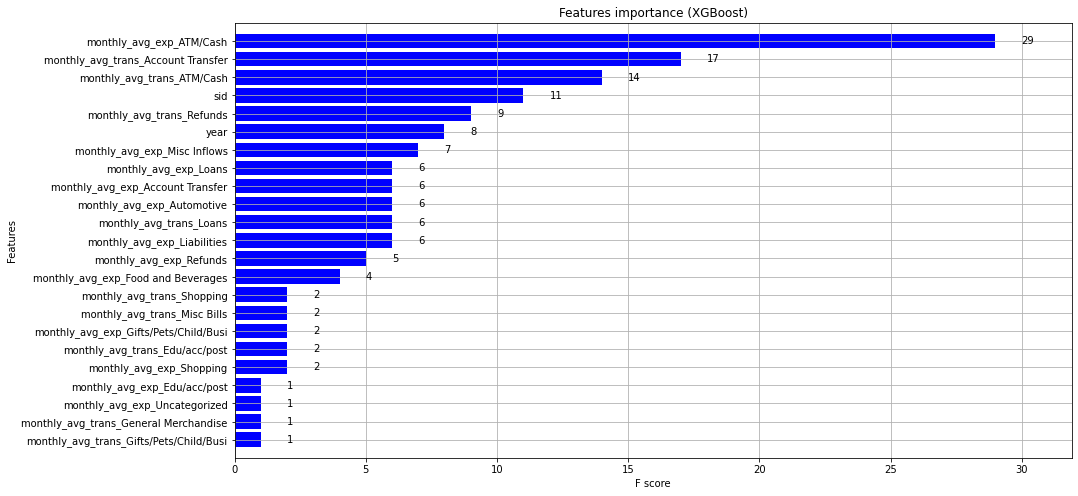

In [47]:
# Plotting feature importance for the model
fig, (ax) = plt.subplots(ncols=1, figsize=(15,8))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="blue") 
plt.show()

# 7. Conclusion

1. I have tried combining different categories together and the features in the final model are the ones which gave the best result compared to other combinations. 
2. The data provided is very limited as there were only around 59 customers and we wanted to estimate annual salary for these customers. This caused the model to overfit and provide inaccuarte results. If more data was provided, we could've gotten a better model with better results.
3. Data for 2021 is only till september month and we don't have data for the rest of the month, due to which I had to extrapolate the salary information for the reamaining months. This method is not very accurate but can be taken as a baseline. 
